In [1]:
### Get Quality Metrics

# Import libraries
import pandas as pd
import numpy as np
from obspy.clients.fdsn import Client
from obspy import UTCDateTime, Trace
client = Client("IRIS")

In [2]:
# want to read a specific quality url
netID='XE'
staID='CC01'
locID=''
chaID='BHZ'

url =f'https://obsic-metrics.whoi.edu/static/images/quality/{netID}/{staID}_{chaID}.txt'

# read in the data
data = pd.read_csv(url, delimiter=',', header=2, names=['DateTime', 'Quality'])

# now specify start and end window
starttime = '2018-07-26T00:00:00'
endtime = '2018-07-26T23:59:54'

st = client.get_waveforms(netID, staID, locID, chaID, UTCDateTime(starttime), UTCDateTime(endtime))

mask = (data['DateTime'] >= starttime) & (data['DateTime'] <= endtime)
filtered_data = data.loc[mask]

In [4]:
# put Quality into one long string
quality_string = ''.join(data['Quality'].astype(str).values)

startindex = int((UTCDateTime(starttime)-UTCDateTime(data['DateTime'].iloc[0]))/3600)
endindex = int((UTCDateTime(endtime)-UTCDateTime(data['DateTime'].iloc[0]))/3600)

qualarr=np.array([int(char) for char in quality_string[startindex:endindex+1]])

stats = {'network': netID, 'station': staID, 'location': locID, 'channel': 'BQZ',
         'npts': len(qualarr), 'sampling_rate': 1/3600,
         'starttime': UTCDateTime(starttime)}
tr = Trace(data=qualarr, header=stats)
st += tr

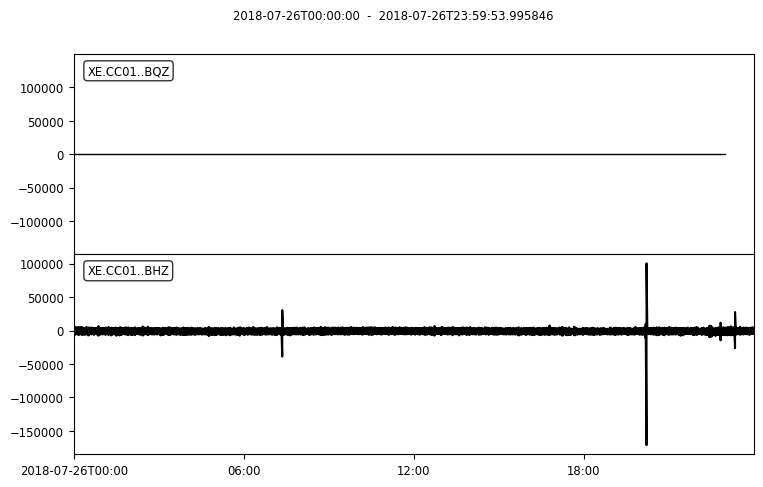

In [5]:
st.plot();